In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import datetime as dt
import yfinance as yf

In [2]:
end = dt.datetime.today()
start = end - dt.timedelta((365*5) + 365 + 60 + 60)

url = ('https://www.ssga.com/us/en/institutional/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx')
tickers = list(pd.read_excel(url, header=4).Ticker.dropna())
bench = ['SPY', 'IWM', 'DIA']

prc = yf.download(tickers + bench, start, end)['Adj Close']
vol = yf.download(tickers, start, end).Volume
ret = prc.resample('M').last().pct_change()

[*********************100%***********************]  509 of 509 completed

3 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- CASH_USD: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
[*********************100%***********************]  506 of 506 completed

3 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- CASH_USD: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


In [3]:
class MomentumFactorsFTW:
    
    def __init__(self, prc_slice, vol_slice):
        self.prc = prc_slice
        self.vol = vol_slice
        
    def trend_line(self):
        self.tr_slope = ((self.prc.rolling(20, min_periods = 1).mean()).iloc[-1] 
                         - (self.prc.rolling(20, min_periods = 1).mean()).iloc[-252]) / (self.prc.rolling(20, min_periods = 1).mean()).iloc[-252].mean()  
        return (self.tr_slope - self.tr_slope.std()) / self.tr_slope.std()
        
    def percent_above_low(self):
        self.pct_abv = (self.prc.rolling(20, min_periods = 1).mean().iloc[-1] - self.prc.rolling(20, min_periods = 1).mean().iloc[-260:].min()) / (self.prc.rolling(20, min_periods = 1)).mean().iloc[-260:].min()
        return (self.pct_abv - self.pct_abv.std()) / self.pct_abv.std()
    
    def price_osc(self):
        self.prc_osc = (((prc.rolling(20).mean().iloc[-1] * (2/(1+4))) 
                         + prc.rolling(20).mean().iloc[-2]*(1-(2/(1+4))))
                        - (prc.rolling(20).mean().iloc[-1] * (2/(1+52))) 
                        + prc.rolling(20).mean().iloc[-2]*(1-(2/(1+52))))  / ((prc.rolling(20).mean().iloc[-1] * (2/(1+52))) + prc.rolling(20).mean().iloc[-2]*(1-(2/(1+52))))
        return (self.prc_osc - self.prc_osc.std()) / self.prc_osc.std()
    
    def three_qtr_ret(self):
        self.qtr_returns = self.prc.pct_change(periods=(int(39*4.84))).rolling(20).mean()[-1:]
        return (self.qtr_returns - self.qtr_returns.std(axis=1)[0]) / self.qtr_returns.std(axis=1)[0]
    
    def vol_price_trend(self):
        self.pvt = (vol * prc.pct_change()).sum()
        return (self.pvt - self.pvt.std()) / self.pvt.std()
    
    def avg_dd(self):
        self.dd = (self.prc.rolling(5).max()
                   - self.prc.rolling(5).min()
                  ).mean()
        return (self.dd - self.dd.std()) / self.dd.std()
    
    def baskets(self):
        self.factor_agg = (self.three_qtr_ret() 
                           + self.avg_dd()
                           + self.trend_line()
                           + self.price_osc()
                           + self.percent_above_low()
                           + self.vol_price_trend()
                          )
        self.factors = self.factor_agg.iloc[0]
        return (list(self.factors.nlargest(10).index)
                ,list(self.factors.nsmallest(10).index)
               )

In [4]:
# Create date list index
date_list = pd.DataFrame(pd.date_range(dt.datetime.today() - dt.timedelta(1825)                  # the date can be changed manually 
                                       ,dt.datetime.today()
                                       ,freq='M'
                                      ).date
                        )
date_list.rename(columns={0:'date'}, inplace=True)
date_list.date = pd.to_datetime(date_list.date)


# 1st Loop - runs algorithm
long_list = pd.DataFrame()
short_list = pd.DataFrame()

for date in date_list.date:
    #slc_start = date - dt.timedelta(365+60)
    prc_slc = prc.loc[:date]
    
    mf = MomentumFactorsFTW(prc_slc, vol)
    long, short = mf.baskets()
    
    #print(long)
    long_list[date] = long
    short_list[date] = short

In [5]:
# 2nd loop - calculates and returns selected returns
long_returns = pd.DataFrame()
short_returns = pd.DataFrame()
i = 1

for date in date_list.date[:-1]:
    y = date_list.date.shift(-i).loc[0]
    i += 1
    
    long_returns = long_returns.append(ret[long_list.T.loc[date]].loc[y])
    short_returns = short_returns.append(ret[short_list.T.loc[date]].loc[y])
    
    #create a column to get the total return per month for long and short
    #add the equal weights, .05 for each long and short
    #long -short, Negative shorts are positive
    #then graph the return over time

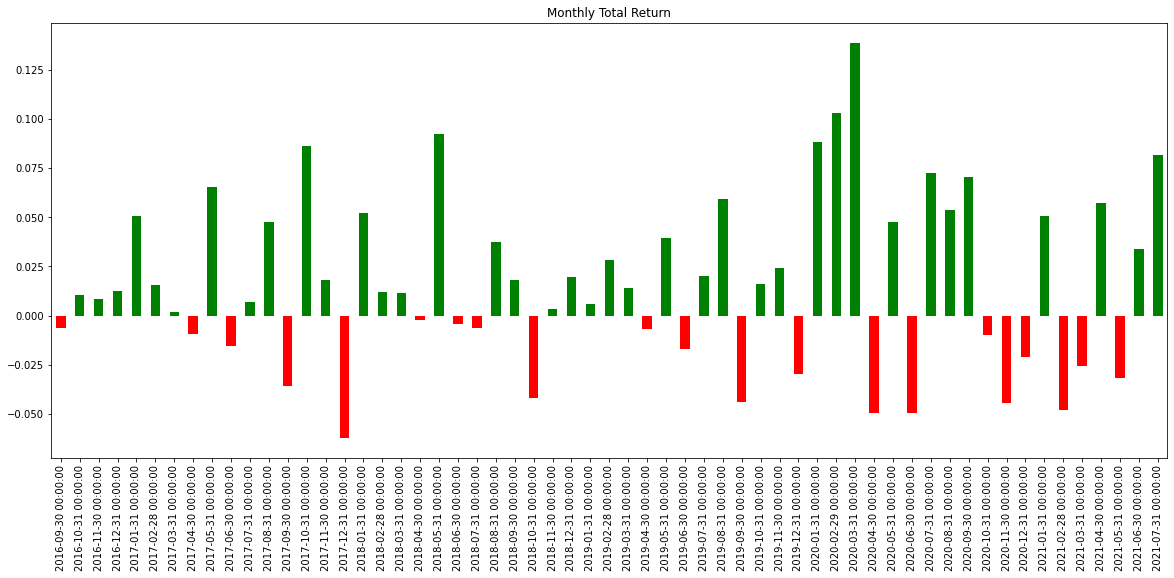

In [9]:
tot_sum = pd.DataFrame()
tot_sum['tot_long'] = (long_returns*.05).sum(axis=1)
tot_sum['tot_short'] = (short_returns *.05).sum(axis=1)
tot_sum['tot_returns'] = tot_sum['tot_long'] - tot_sum['tot_short']
tot_sum

fig = plt.figure()
tot_sum['pos'] = tot_sum['tot_returns'] > 0
plt.title('Monthly Total Return')
tot_sum['tot_returns'].plot.bar(
                color=tot_sum['pos'].map({True: 'g', False: 'r'}),
                figsize=(20,8),
                )
fig.savefig('relative_monthly.png')

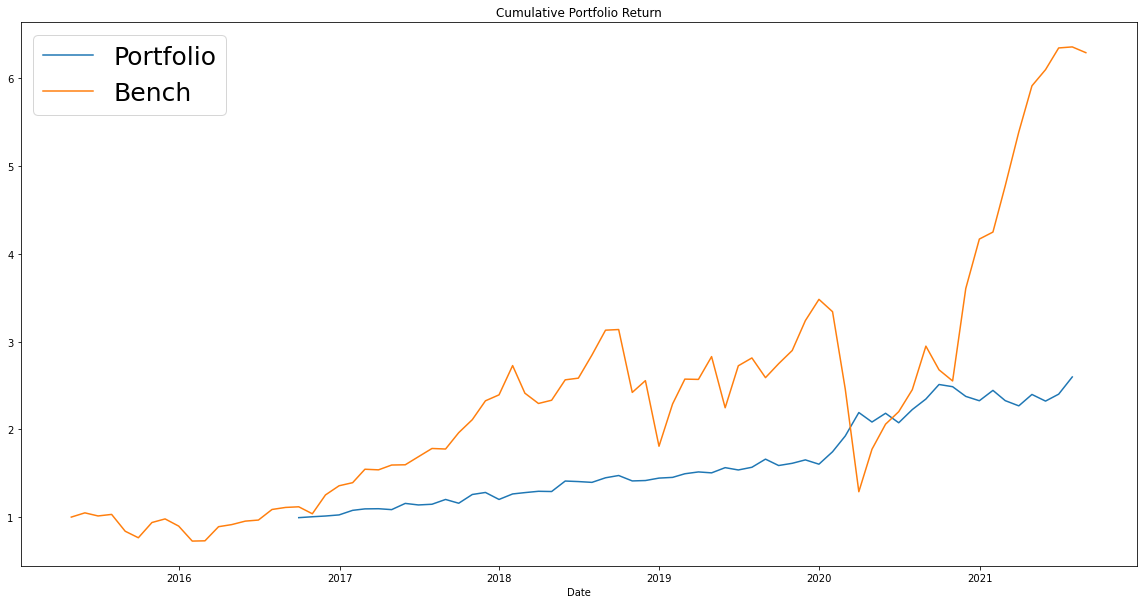

In [10]:
plt.figure(figsize=(20,10))
plt.xlabel('Date')
plt.title('Cumulative Portfolio Return')
plt.plot(((long_returns*.05).sum(axis=1) - (short_returns*.05).sum(axis=1) + 1).cumprod(), label = 'Portfolio')
plt.plot((prc[bench].resample('M').last().pct_change().sum(axis=1)+1).cumprod(), label = 'Bench')
plt.legend(fontsize = 25)
plt.show()

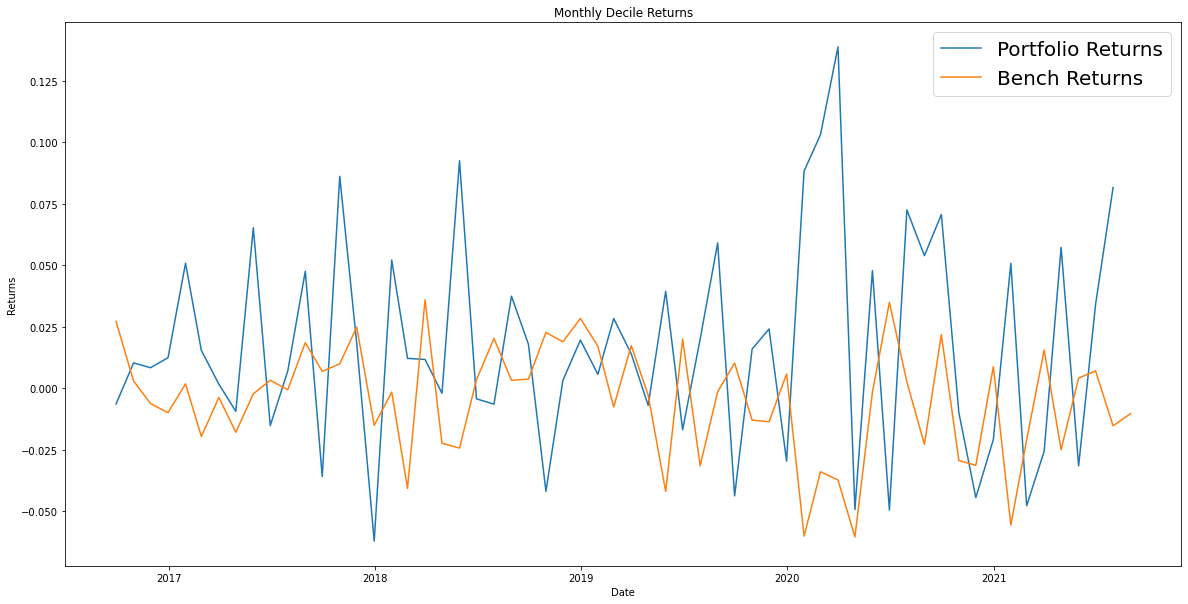

In [11]:
plt.figure(figsize=(20,10))
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Monthly Decile Returns')
plt.plot((long_returns*.05).sum(axis=1) - (short_returns*.05).sum(axis=1), label = 'Portfolio Returns')
plt.plot((prc[bench].loc['2016-09-29':].pct_change()).sum(axis = 1).resample('M').last(), label = 'Bench Returns')
plt.legend(fontsize = 20)
plt.show()